In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim import Adam
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import time
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from typing import List, Optional
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<div class="anchor" id="top" style=" margin-right: auto; margin-left: auto; padding: 10px; font-size : 15px; background-color: #DFFFFE; border-radius: 2px; font-color :  #581845  ; border: 2px solid #581845;"> Histopathologic Cancer Detection : Identify metastatic tissue in histopathologic scans of lymph node sections <b>This is a typical image classification problem.</b>

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 15px;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
 
- [1. Dataset Description](#1)
- [2. Exploratory Data Analysis](#2)
    - [2.1 Label Distribution](#2.1)
    - [2.2 Duplicate Values](#2.2)
- [3. DModel Architecture](#3)
    - [3.1 Create Datesets](#3.1)  
    - [3.2 Data Augmentation](#3.2) 
    - [3.3 VGG](#3.3)
    - [3.4 ResNet](#3.4)
- [4. Results and Analysis](#4)
- [5. Conclusion](#5)

# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Dataset Description </p>   </span></font></center> 

# 1. Dataset Description

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
    
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. **A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label**. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, **however, the version presented on Kaggle does not contain duplicates**. We have otherwise maintained the same data and splits as the PCam benchmark.
    
Data Source By: 
- Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

In [6]:
labels_df = pd.read_csv('data/train_labels.csv')
print(labels_df.head())
labels_df.shape

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


(220025, 2)

In [9]:
train_data_sz = len(os.listdir('data/train'))
test_data_sz = len(os.listdir('data/test'))
print(f'The size of training data is: {train_data_sz}')
print(f'The size of test data is: {test_data_sz}')

The size of training data is: 220025
The size of test data is: 57458


(96, 96, 3)


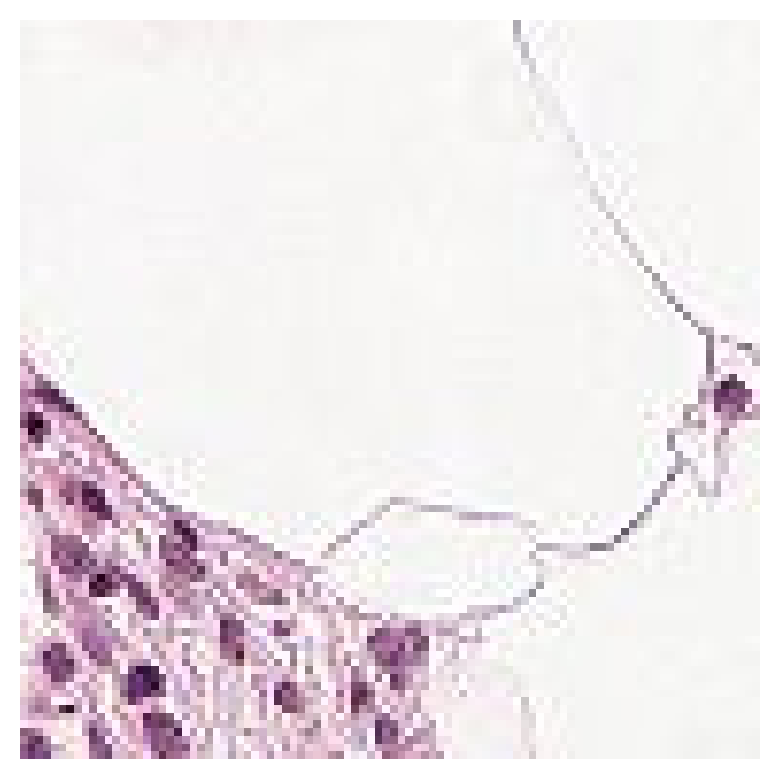

In [10]:
fname = 'data/train/' + labels_df.id[0] + '.tif'
img = Image.open(fname)
idcol = ImageDraw.Draw(img)
plt.imshow(np.array(img))
idcol.rectangle(((0,0),(95,95)),outline='white')
plt.axis('off')
print(np.array(img).shape)

# <a id="2"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Exploratory Data Analysis </p>   </span></font></center> 
# 2. Exploratory Data Analysis

## 2.1 Label Distribution
# <a id="2.1"></a>

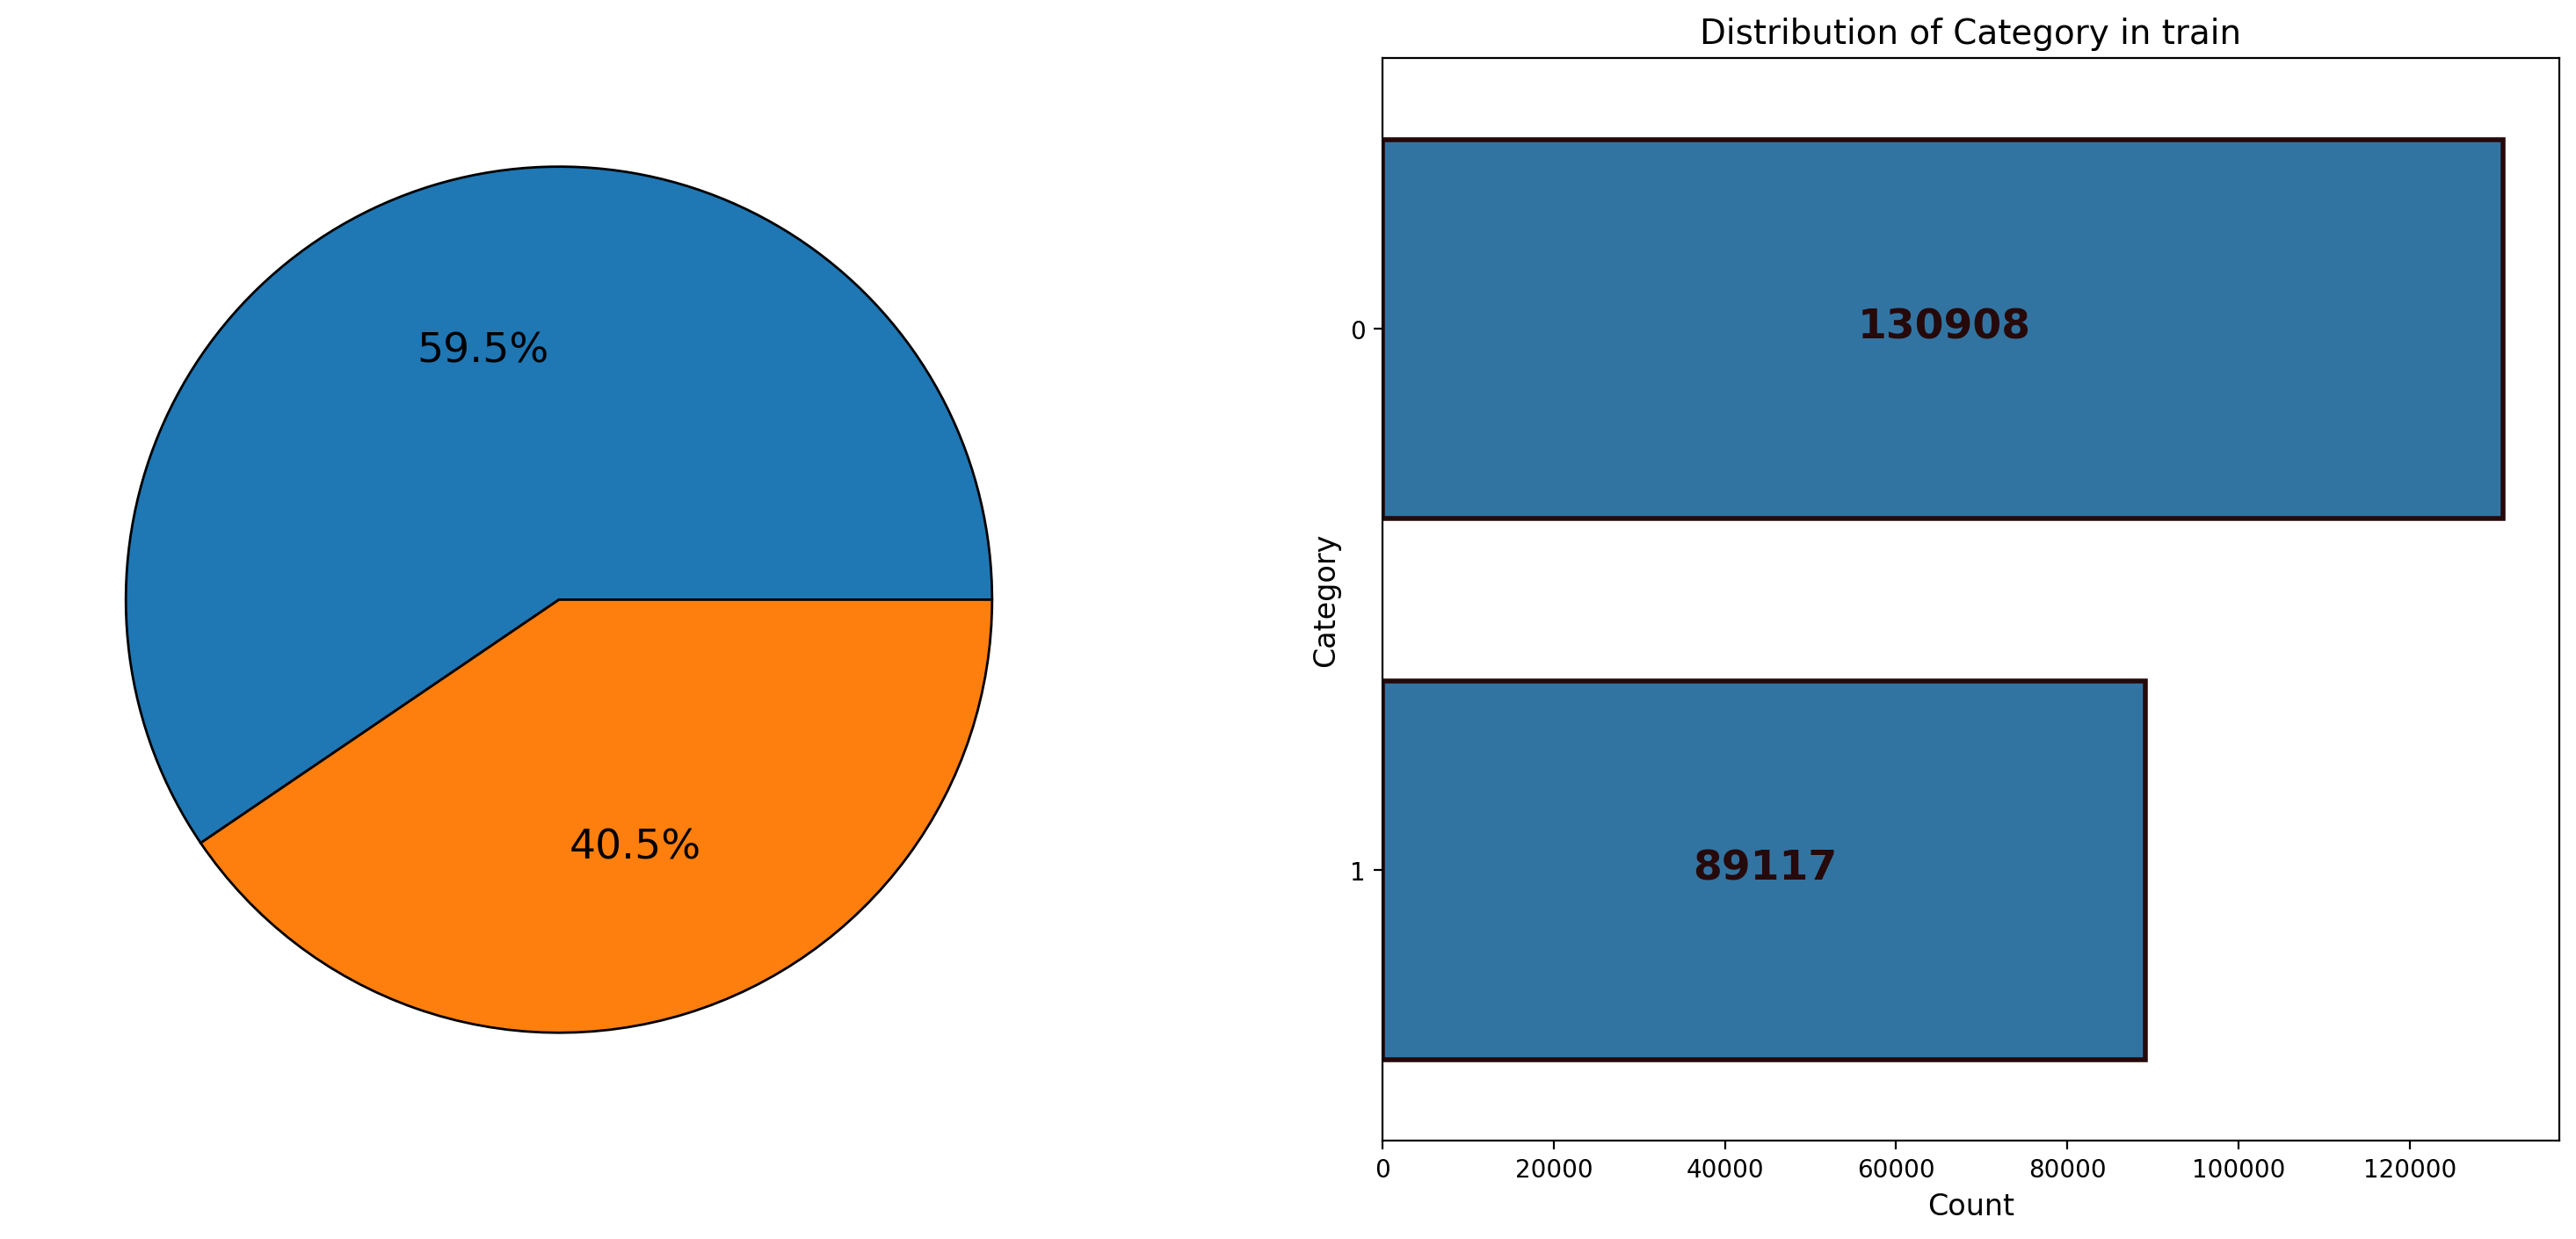

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(19,8))

wedges = ax[0].pie(autopct='%1.1f%%', x=labels_df['label'].value_counts())
p = sns.countplot(y="label", data=labels_df, edgecolor='#26090b', linewidth=2, width=0.7)
wedges[2][0].set_fontsize(17)
wedges[2][1].set_fontsize(17)
wedges[0][0].set_edgecolor('black')
wedges[0][1].set_edgecolor('black')
wedges[1][0].set_fontsize(17)
wedges[1][1].set_fontsize(17)

for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),)
    
plt.title("Distribution of Category in train", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.savefig('figures/target_distribution.svg')
plt.show()

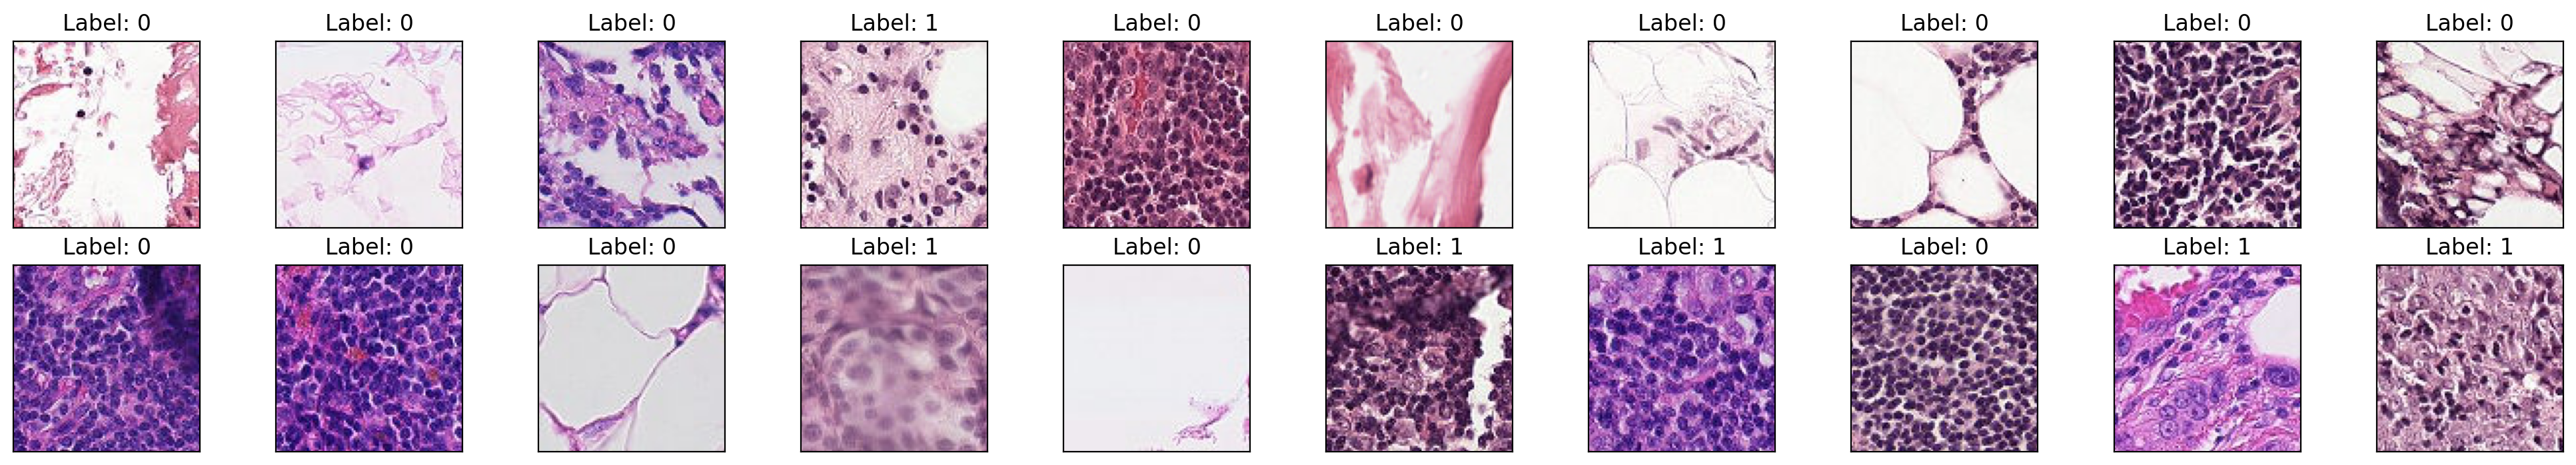

In [15]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("data/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open('data/train/' + img)
    plt.imshow(im)
    lab = labels_df.loc[labels_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')
    
plt.savefig('figures/show.svg')
plt.show()

## 2.2 Duplicate Values
# <a id="2.2"></a>
As the problem already mentions that there are no duplicate values in the data, there is no need to process it.

# <a id="3"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">DModel Architecture </p>   </span></font></center> 
# 3. DModel Architecture

## 3.1 Create Datesets
# <a id="3.1"></a>

In [16]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):

        # Get Image File Names
        cdm_data = os.path.join(data_dir, data_type)  # directory of files

        file_names = os.listdir(cdm_data)  # get list of images in that directory
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names]  # get the full path to images

        # Get Labels
        labels_data = os.path.join(data_dir, "train_labels.csv")
        labels_df = pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True)  # set data frame index to id
        if data_type == "train":
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names]  # obtained labels from df
        else:
            self.labels = None
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)  # size of dataset

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image)  # Apply Specific Transformation to Image
        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image,

## 3.2 Data Augmentation
# <a id="3.1"></a>
Data augmentation including horizontal flipping, vertical flipping, rotating, normalization

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
])

In [18]:
# Define an object of the custom dataset for the train folder.
data_dir = 'data/'
train_dataset = MyDataset(data_dir, transform, data_type='train')
test_dataset = MyDataset(data_dir, transform, data_type='test')

In [19]:
train_size, valid_size = 0.9, 0.1
train_dataset, valid_dataset = random_split(train_dataset, 
                                           [train_size, valid_size])


## 3.3 VGG
The basic building block of CNNs is a sequence of the following: (i) a convolutional layer with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such as max-pooling to reduce the resolution. One of the problems with this approach is that the spatial resolution decreases quite rapidly. In particular, this imposes a hard limit of $\log_2 d$
 convolutional layers on the network before all dimensions 
($d$) are used up.

Back to VGG: a VGG block consists of a sequence of convolutions with $3 \times 3$ kernels with padding of 1 (keeping height and width) followed by $2 \times 2$ a max-pooling layer with stride of 2 (halving height and width after each block). In the code below, we define a function called vgg_block to implement one VGG block.

![VGG Framework](figures/vgg.png)


In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.conv(x))
        return x


class VGGBase(nn.Module):

    def __init__(self, n_blocks: List[int], n_channels: List[int],
                 img_channels: int = 3):
        super().__init__()
        blocks = []

        pre_channels = img_channels
        for i, channels in enumerate(n_channels):
            blocks.append(VGGBlock(
                pre_channels, channels
            ))
            pre_channels = channels

            for _ in range(n_blocks[i] - 1):
                blocks.append(VGGBlock(
                    channels, channels
                ))
            blocks.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        x = self.blocks(x)
        return x

    
class CancerVGGNet(nn.Module):

    def __init__(self, output_dim: int, n_blocks: List[int],
                 n_channels: List[int], img_channels: int = 3,
                 dropout: float = 0.5):
        super().__init__()
        self.backbone = VGGBase(
            n_blocks, n_channels, img_channels
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(4096)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.LazyLinear(4096)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.LazyLinear(output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.dropout1(self.act1(self.fc1(x)))
        x = self.dropout2(self.act2(self.fc2(x)))
        logit = self.fc3(x)
        return logit


## 3.4 ResNet
Let’s focus on a local part of a neural network, as depicted in [Fig 2](https://d2l.ai/_images/residual-block.svg) . Denote the input by $x$. We assume that $f(x)$, the desired underlying mapping we want to obtain by learning, is to be used as input to the activation function on the top. On the left, the portion within the dotted-line box must directly learn $f(x)$. On the right, the portion within the dotted-line box needs to learn the residual mapping $g(x)=f(x)-x$, which is how the residual block derives its name. If the identity mapping $f(x)=x$ is the desired underlying mapping, the residual mapping amounts to $g(x)=0$ and it is thus easier to learn: we only need to push the weights and biases of the upper weight layer (e.g., fully connected layer and convolutional layer) within the dotted-line box to zero. The right figure illustrates the residual block of ResNet, where the solid line carrying the layer input $x$ to the addition operator is called a residual connection (or shortcut connection). With residual blocks, inputs can forward propagate faster through the residual connections across layers. In fact, the residual block can be thought of as a special case of the multi-branch Inception block: it has two branches one of which is the identity mapping.

ResNet has VGG’s full $3 \times 3$ convolutional layer design. The residual block has two $3 \times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1 \times 1$ convolutional layer to transform the input into the desired shape for the addition operation. 


![ResNet Framework](figures/resnet.png)


![residual-block](figures/residual-block.png)

In [ ]:
class ShortcutProjection(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        return self.bn(self.conv(x))


class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels or stride != 1:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.act2(x + shortcut)


class BottleneckResidualBlock(nn.Module):

    def __init__(self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels or stride != 1:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()

        self.act3 = nn.ReLU()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.act3(x + shortcut)


class ResNetBase(nn.Module):
    def __init__(self, n_blocks: List[int], n_channels: List[int],
                 bottlenecks: Optional[List[int]] = None):
        super().__init__()

        blocks = []
        prev_channels = n_channels[0]

        """
        n_blocks = [2, 2, 2, 2]
        n_channels = [64, 128, 256, 512]
        """
        for i, channels in enumerate(n_channels):
            stride = 1 if len(blocks) == 0 else 2

            if bottlenecks is not None:
                blocks.append(BottleneckResidualBlock(
                    prev_channels, bottlenecks[i], channels, stride
                ))
            else:
                blocks.append(ResidualBlock(
                    prev_channels, channels, stride
                ))

            prev_channels = channels
            for _ in range(n_blocks[i] - 1):
                stride = 1
                if bottlenecks is not None:
                    blocks.append(BottleneckResidualBlock(
                        prev_channels, bottlenecks[i], channels, stride
                    ))

                else:
                    blocks.append(ResidualBlock(channels, channels, stride=stride))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        x = self.blocks(x)
        return x
    

class CancerResNet(nn.Module):
    
    def __init__(self, output_dim: int, n_blocks: List[int], n_channels: List[int],
                 img_channels: int = 3, first_kernel_size: int = 3):
        super().__init__()
        self.conv = nn.Conv2d(img_channels, n_channels[0], kernel_size=first_kernel_size,
                              stride=2, padding=first_kernel_size // 2)
        self.bn = nn.BatchNorm2d(n_channels[0])
        self.act = nn.ReLU()
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.backbone = self.get_resnet_layer(n_blocks, n_channels)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=n_channels[-1], out_features=output_dim)

    def get_resnet_layer(self, n_blocks: List[int], n_channels: List[int]):
        return ResNetBase(
            n_blocks, n_channels,
        )

    def forward(self, x):
        x = self.bn(self.conv(x))
        x = self.act(x)
        x = self.max_pool(x)
        x = self.backbone(x)
        x = self.flatten(self.avg_pool(x))
        logit = self.fc(x)
        return logit


### Train Configs

In [ ]:
resnet11_args = {
    'model':{
        'name': 'CancerResNet11',
        'output_dim': 2,
        'n_blocks': [1, 1, 1, 1],
        'n_channels': [64, 128, 256, 512],
    },
    'optimizer':{
        'lr': 0.001,
        'weight_decay': 0.0005
    },
    'dataset':{
        'data_dir': '/kaggle/input/histopathologic-cancer-detection/',
        'batch_size': 512,
        'split': {
            'train': 0.9,
            'valid': 0.1,
            'test': 0.1
        }
    },
    'train':{
        'epochs': 1,
        'device': 'cuda:0',
        'save_path': './checkpoints/',
        'log_path': './logs/',
        'save_every': 2,
        'seed': 3407
    },
    'test':{
        'device': 'cuda:0',
        'checkpoint': './checkpoints/',
        'log_path': './logs/',
    }
}

resnet18_args = {
    'model':{
        'name': 'CancerResNet34',
        'output_dim': 2,
        'n_blocks': [2, 2, 2, 2],
        'n_channels': [64, 128, 256, 512],
    },
    'optimizer':{
        'lr': 0.001,
        'weight_decay': 0.0005
    },
    'dataset':{
        'data_dir': '/kaggle/input/histopathologic-cancer-detection/',
        'batch_size': 512,
        'split': {
            'train': 0.9,
            'valid': 0.1,
            'test': 0.1
        }
    },
    'train':{
        'epochs': 1,
        'device': 'cuda:0',
        'save_path': './checkpoints/',
        'log_path': './logs/',
        'save_every': 2,
        'seed': 3407
    },
    'test':{
        'device': 'cuda:0',
        'checkpoint': './checkpoints/',
        'log_path': './logs/',
    }
}

vgg11_args = {
    'model':{
        'name': 'CancerVGGNet16',
        'output_dim': 2,
        'n_blocks': [1, 1, 2, 2, 2],
        'n_channels': [64, 128, 256, 512, 512],
    },
    'optimizer':{
        'lr': 0.001,
        'weight_decay': 0.0005
    },
    'dataset':{
        'data_dir': '/kaggle/input/histopathologic-cancer-detection/',
        'batch_size': 512,
        'split': {
            'train': 0.9,
            'valid': 0.1,
            'test': 0.1
        }
    },
    'train':{
        'epochs': 1,
        'device': 'cuda:0',
        'save_path': './checkpoints/',
        'log_path': './logs/',
        'save_every': 2,
        'seed': 3407
    },
    'test':{
        'device': 'cuda:0',
        'checkpoint': './checkpoints/',
        'log_path': './logs/',
    }
}

vgg13_args = {
    'model':{
        'name': 'CancerVGGNet13',
        'output_dim': 2,
        'n_blocks': [2, 2, 2, 2, 2],
        'n_channels': [64, 128, 256, 512, 512],
    },
    'optimizer':{
        'lr': 0.001,
        'weight_decay': 0.0005
    },
    'dataset':{
        'data_dir': '/kaggle/input/histopathologic-cancer-detection/',
        'batch_size': 512,
        'split': {
            'train': 0.9,
            'valid': 0.1,
            'test': 0.1
        }
    },
    'train':{
        'epochs': 1,
        'device': 'cuda:0',
        'save_path': './checkpoints/',
        'log_path': './logs/',
        'save_every': 2,
        'seed': 3407
    },
    'test':{
        'device': 'cuda:0',
        'checkpoint': './checkpoints/',
        'log_path': './logs/',
    }
}

In [ ]:
def Model(params):
    name = params['name']

    model = None
    if 'ResNet' in name:
        model = CancerResNet
    elif 'VGG' in name:
        model = CancerVGGNet

    constructor_params = {k: v for k, v in
                          filter(lambda item: item[0] in model.__init__.__code__.co_varnames, params.items())}
    return model(**constructor_params)


def get_logger(save_path):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(save_path)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)
    return logger


def cancer(params):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomRotation(20),
        transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    ])

    train_dataset = MyDataset(
        data_dir=params['data_dir'],
        transform=train_transform,
        data_type='train'
    )

    test_dataset = MyDataset(
        data_dir=params['data_dir'],
        transform=test_transform,
        data_type='test'
    )

    train_size = int(params['split']['train'] * len(train_dataset))
    valid_size = int(params['split']['valid'] * len(train_dataset))
    train_other_size = len(train_dataset) - train_size - valid_size

    train_datasets = random_split(
        train_dataset,
        [train_size, valid_size, train_other_size]
    )

    test_size = int(params['split']['test'] * len(test_dataset))
    test_other_size = len(test_dataset) - test_size

    test_datasets = random_split(
        test_dataset,
        [test_size, test_other_size]
    )

    train_dataset, valid_dataset, _ = train_datasets
    test_dataset, _ = test_datasets

    return train_dataset, valid_dataset, test_dataset


def train(args):
    torch.manual_seed(args['train']['seed'])
    random.seed(args['train']['seed'])

    epochs = args['train']['epochs']
    bs = args['dataset']['batch_size']
    device_str = args['train']['device'] if torch.cuda.is_available() else 'cpu'

    model = Model(args['model'])
    model.to(device_str)
    
    print(model)
    
    optimizer = Adam(model.parameters(), 
                     lr=args['optimizer']['lr'], 
                     weight_decay=args['optimizer']['weight_decay'])
    
    # scheduler = Scheduler(optimizer, args['scheduler'])

    loss_fn = CrossEntropyLoss()

    if 'checkpoint' in args['train'].keys():
        model.load_state_dict(torch.load(args['train']['checkpoint']))

    log_path = f"{args['train']['log_path']}{args['model']['name'].lower()}/"
    os.makedirs(log_path, exist_ok=True)
    logger = get_logger(log_path + 'train.log')

    save_path = f"{args['train']['save_path']}{args['model']['name'].lower()}/"
    save_name = f'{args["model"]["name"]}.pth'
    os.makedirs(save_path, exist_ok=True)

    train_dataset, valid_dataset, test_dataset = cancer(args['dataset'])

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=bs,
        shuffle=True
    )

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=bs,
        shuffle=True
    )

    init_time = time.time()
    best_loss = 99999999.0

    epochs_npz = np.array([ep for ep in range(epochs)])
    train_loss_npz = []
    valid_loss_npz = []
    train_acc_npz = []
    valid_acc_npz = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        model.train()

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        for batch, (imgs, labels) in enumerate(train_data_loader):
            # forward
            imgs, labels = imgs.to(device_str), labels.to(device_str)
            preds = model(imgs)
            loss = loss_fn(preds, labels)

            y_actual = labels.data.cpu().numpy()
            y_pred = preds.argmax(1).detach().cpu().numpy()
            train_acc += accuracy_score(y_actual, y_pred)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch, (imgs, labels) in enumerate(valid_data_loader):
                imgs, labels = imgs.to(device_str), labels.to(device_str)
                preds = model(imgs)
                loss = loss_fn(preds, labels)

                y_actual = labels.data.cpu().numpy()
                y_pred = preds.argmax(1).detach().cpu().numpy()
                valid_acc += accuracy_score(y_actual, y_pred)
                valid_loss += loss.item()

        train_loss /= len(train_data_loader)
        valid_loss /= len(valid_data_loader)
        train_acc /= len(train_data_loader)
        valid_acc /= len(valid_data_loader)

        train_loss_npz.append(train_loss)
        valid_loss_npz.append(valid_loss)
        train_acc_npz.append(train_acc)
        valid_acc_npz.append(valid_acc)

        cond1 = valid_loss < best_loss

        if cond1:
            best_loss = valid_loss
            state_dict = model.state_dict()
            torch.save(state_dict, save_path + save_name)

        end = time.time()

        print_str = f'{device_str} '
        print_str += f'epoch: {epoch + 1}/{epochs} '
        print_str += f'train_loss: {train_loss:.4f} '
        print_str += f'valid_loss: {valid_loss:.4f} '
        print_str += f'epoch_time: {(end - start):.3f} sec'
        logger.info(print_str)

    last_time = time.time()
    print(save_path + save_name)
    model = Model(args['model']).to(device_str)
    model.load_state_dict(torch.load(save_path + save_name))

    train_metrics = evaluate(model, train_data_loader, device_str)
    valid_metrics = evaluate(model, valid_data_loader, device_str)

    print_str = '\n'

    for name, val in train_metrics:
        print_str += f'train_{name}: {val:.3f} '

    for name, val in valid_metrics:
        print_str += f'valid_{name}: {val:.3f} '

    print_str += f'total_time: {(last_time - init_time):.3f} sec'
    logger.info(print_str)

    np.savez_compressed(
        log_path + 'losses.npz',
        epochs_npz,
        train_loss_npz,
        valid_loss_npz,
        train_acc_npz,
        valid_acc_npz
    )
    
    
def evaluate(model, dataloader, device):
    model.eval()
    accuracy = 0.0
    precision = 0.0
    recall = 0.0
    f1 = 0.0

    length = len(dataloader)

    with torch.no_grad():
        for batch, (imgs, labels) in enumerate(dataloader):
            # imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1).cpu().numpy()

            tmp_accuracy = accuracy_score(labels.cpu().numpy(), preds)
            tmp_precision = precision_score(labels.cpu().numpy(), preds, average='weighted')
            tmp_recall = recall_score(labels.cpu().numpy(), preds, average='weighted')
            tmp_f1 = f1_score(labels.cpu().numpy(), preds, average='weighted')

            accuracy += tmp_accuracy
            precision += tmp_precision
            recall += tmp_recall
            f1 += tmp_f1

    accuracy /= length
    precision /= length
    recall /= length
    f1 /= length

    acc_tup = ('accuracy', accuracy)
    prec_tup = ('precision', precision)
    rec_tup = ('recall', recall)
    f1_tup = ('f1', f1)

    return acc_tup, prec_tup, rec_tup, f1_tup

## Training
Due to the long training time, the code is no longer run in the notebook, see the logs in the `./logs` folder for more details.

In [ ]:
train(resnet11_args)

In [ ]:
train(resnet18_args)

In [ ]:
train(vgg11_args)

In [ ]:
train(vgg13_args)

# <a id="4"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Results and Analysis </p>   </span></font></center> 
# 4. Results and Analysis

We used four model architectures, VGG-11, VGG-13, ResNet-11 and ResNet-18, and compared the impact of these four models.

In [ ]:
plot_args = {
    'models': ['CancerVGGNet11', 'CancerVGGNet13', 'CancerResNet11', 'CancerResNet18'],
    'datasets': ['cancer'],
    'log_path': './logs/',
    'plot_path': './plot/',
    'dpi': 70,
    'clip': [0.0, 3.0]
}

In [ ]:
def _plot(
    ax,
    idx,
    dataset,
    log_path,
    model,
    clip_min,
    clip_max,
    metric
):
    ax.grid(True)

    name = f'{log_path}/{model.lower()}'
    name += '/losses.npz'

    npz = np.load(name)

    epochs = npz['arr_0']
    train_loss = npz['arr_1']
    valid_loss = npz['arr_2']
    train_acc = npz['arr_3']
    valid_acc = npz['arr_4']

    train_loss = np.clip(
        train_loss,
        a_min=clip_min,
        a_max=clip_max
    )

    valid_loss = np.clip(
        valid_loss,
        a_min=clip_min,
        a_max=clip_max
    )

    train_acc = np.clip(
        train_acc,
        a_min=clip_min,
        a_max=clip_max
    )

    valid_acc = np.clip(
        valid_acc,
        a_min=clip_min,
        a_max=clip_max
    )

    if metric == 'Loss':
        if idx % 2 == 0:
            ax.plot(
                epochs+1,
                train_loss,
            )
        else:
            ax.plot(
                epochs+1,
                valid_loss,
            )
    elif metric == 'Accuracy':
        if idx % 2 == 0:
            ax.plot(
                epochs+1,
                train_acc,
            )
        else:
            ax.plot(
                epochs+1,
                valid_acc,
            )
            
            
def plot(args):
    num_subplots = len(args['datasets'])

    models = args['models']
    datasets = args['datasets']

    clip_min, clip_max = args['clip']

    plot_path = args['plot_path']
    log_path = args['log_path']

    dpi = args['dpi']
    os.makedirs(plot_path, exist_ok=True)

    metrics = ['Loss', 'Accuracy']
    datasets_type = ['Train', 'Valid']
    for metric in metrics:
        _, axes = plt.subplots(num_subplots, 2, figsize=(15, 5), dpi=dpi)
        for i, ax in enumerate(axes):
            for model in models:
                plt.subplots_adjust(
                    left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3
                )

                _plot(
                    ax,
                    i,
                    datasets[i // 2],
                    log_path,
                    model,
                    clip_min,
                    clip_max,
                    metric
                )
            ax.set_title(datasets_type[i] + ' ' + metric)
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric)
            ax.legend(models)

        plt.savefig(f'{plot_path}{metric}.pdf', dpi=dpi)

    plt.cla()
    plt.clf()

In [ ]:
plot(plot_args)


![loss](plot/Loss.png)

<p>

| Model     | Accuracy (valid) | Precision (valid) | Recall (valid) | f1 score (valid) | total time (sec) |
|-----------|------------------|-------------------|----------------|------------------|------------------|
| VGG-11    | 0.936             | 0.938              |   0.936             |         0.936         |    47865.033              |
| VGG-13    | 0.969            | 0.970             |     0.969           |       0.969          |      51699.484            |
| ResNet-11 | 0.947            | 0.949             | 0.947          | 0.947            |        30975.406         |
| ResNet-13 | 0.953            | 0.955             | 0.953          |    0.953              |  36091.643                 |



From the loss curves, it can be seen that the models basically converge after 50 training rounds, and the best performing model is VGG-13.In addition, comparing the training curves of the training and validation sets, it can be seen that there is a slight overfitting phenomenon in ResNet-18 and VGG-13.


- As can be seen by adjusting the dropout and the number of MLP hidden layers, increasing the dropout and the number of hidden layers accordingly can slightly improve the model performance, but the overall help is not significant.
- Deeper models (e.g. replacing VGG-11 with VGG-13 and ResNet-11 with ResNet-18) have a stronger expressiveness but at the same time increase the risk of overfitting.
- For example, when training VGG-13, the learning rate was adjusted from 0.001 to 0.0001, but when training ResNet-11 and ResNet-18, the learning rate was set at 0.001 and training was still successful, demonstrating to some extent that ResNet is able to effectively solve the gradient vanishing problem.


# <a id="5"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Conclusion </p>   </span></font></center> 
# 5. Conclusion
- Larger models tend to have better fitting capabilities, but are prone to increased risk of overfitting and gradient vanishing problems.
- Using a larger batch size is usually beneficial for model training, but is limited by computational resources.
- The size of the learning rate is key to the success of model training, and adopting an appropriate learning rate can not only accelerate the training efficiency of the model, but also effectively avoid the risk of overfitting.
- The Skip Connection structure proposed by ResNet can effectively solve the problem of gradient disappearance.
- More data enhancement techniques can improve the generalisation ability of the model to avoid overfitting.